In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rc('figure', figsize=(14,8))
plt.rc('font', size=14)

In [3]:
df = pd.read_excel('SSO_Data.xlsx')
df.head()

,SSO_ID,INSPKEY,SERVNO,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,...,Root_Cause,STEPS_TO_PREVENT,SPILL_START_2,SPILL_STOP_2,HRS_2,GAL_2,SPILL_START_3,SPILL_STOP_3,HRS_3,GAL_3
0,6582,567722.0,NaN,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
1,6583,567723.0,NaN,2019-03-10,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
2,6581,567714.0,NaN,2019-03-09,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,...,NaN,NaN,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0
3,6584,567713.0,NaN,2019-03-09,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
4,6580,567432.0,NaN,2019-03-06,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0


In [4]:
df.shape

(3183, 57)

In [8]:
df.

pandas.core.series.Series

In [86]:
features = df.isna().sum()
bad_list = list(features[(features / df.shape[0]) > .4].index)
len(bad_list)

20

In [110]:
info = pd.read_excel('SSO_Description.xlsx')
bad_info = info[info.Field.isin(bad_list)]

In [84]:
info = info[~info.Field.isin(bad_list)].reset_index(drop=True)
info

,Field,Data Description
0,SSO_ID,Internal ID
1,INSPKEY,Not Used
2,REPORTDATE,Date Reported
3,SPILL_ADDRESS,Street number of spill
4,SPILL_ST_NAME,Streen name of spill
5,TOTAL_GAL,Total gallons spilled
6,GALSRET,Gallons returned to collection system
7,GAL,Disregard
8,SPILL_START,When SAWS received information about the spill...
9,SPILL_STOP,Spill actually stopped (no more coming out)


In [79]:
df = df.drop(columns=bad_list)
df.isna().sum()

In [30]:
df.shape

(3183, 37)

In [31]:
df.head()

,SSO_ID,INSPKEY,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,...,PIPETYPE,INSTYEAR,Inches_No,RainFall_Less3,SPILL ADDRESS,NUM_SPILLS_COMPKEY,UNITTYPE,ASSETTYPE,Public Notice,Root_Cause
0,6582,567722.0,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,...,PVC,1997.0,NaN,NaN,3200 THOUSAND OAKS DR,1,GRAVITY,Sewer Main,False,NaN
1,6583,567723.0,2019-03-10,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,...,PVC,1988.0,NaN,NaN,6804 S FLORES,1,GRAVITY,Sewer Main,False,NaN
2,6581,567714.0,2019-03-09,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,...,CP,1955.0,NaN,NaN,215 Audrey Alene Dr,1,GRAVITY,Sewer Main,False,NaN
3,6584,567713.0,2019-03-09,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,...,PVC,1983.0,NaN,NaN,3602 SE MILITARY DR,1,GRAVITY,Sewer Main,False,NaN
4,6580,567432.0,2019-03-06,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,...,CP,1952.0,NaN,NaN,100 PANSY LN,2,GRAVITY,Sewer Main,False,NaN


In [141]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,SSO_ID,INSPKEY,SPILL_ADDRESS,TOTAL_GAL,GALSRET,GAL,HRS,COUNCIL_DISTRICT,Month,Year,Week,PIPEDIAM,PIPELEN,INSTYEAR,Inches_No,RainFall_Less3,NUM_SPILLS_COMPKEY
count,3183.000000,2386.000000,3183.000000,3183.000000,2708.000000,3183.000000,3180.000000,2861.000000,3183.000000,3183.000000,3183.000000,2993.000000,2993.000000,3065.000000,2696.000000,2641.000000,3183.000000
mean,3324.371662,204185.185247,4255.424442,33115.578071,3928.728582,29308.981307,4.323485,4.970290,6.201068,2012.904178,25.676406,11.380722,288.262431,2019.119413,0.476495,0.517490,1.925856
std,1883.181655,161494.531986,4660.968740,311114.890134,59048.789729,301683.157903,38.110123,3.048471,3.584717,2.945651,15.626943,10.173888,465.354265,578.614360,1.309856,1.124533,2.084671
min,1.000000,4288.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,1899.000000,0.000000,0.000000,1.000000
25%,2097.500000,66541.250000,700.000000,50.000000,0.000000,50.000000,0.750000,2.000000,3.000000,2010.000000,12.000000,8.000000,136.000000,1962.000000,0.000000,0.000000,1.000000
50%,2908.000000,154816.500000,2507.000000,250.000000,0.000000,250.000000,1.400000,5.000000,6.000000,2012.000000,24.000000,8.000000,264.500000,1977.000000,0.000000,0.010000,1.000000
75%,5779.500000,316907.000000,6669.000000,2435.000000,0.000000,2400.000000,2.816667,8.000000,9.000000,2015.000000,40.000000,8.000000,351.000000,1994.000000,0.100000,0.460000,2.000000
max,6584.000000,567723.000000,29621.000000,13304550.000000,2385150.000000,13304550.000000,1796.000000,10.000000,12.000000,2019.000000,53.000000,66.000000,11689.350000,9999.000000,9.870000,12.270000,21.000000


In [35]:
list(df.columns)

['SSO_ID',
 'INSPKEY',
 'REPORTDATE',
 'SPILL_ADDRESS',
 'SPILL_ST_NAME',
 'TOTAL_GAL',
 'GALSRET',
 'GAL',
 'SPILL_START',
 'SPILL_STOP',
 'HRS',
 'CAUSE',
 'COMMENTS',
 'ACTIONS',
 'WATERSHED',
 'UNITID',
 'UNITID2',
 'DISCHARGE_TO',
 'DISCHARGE_ROUTE',
 'COUNCIL_DISTRICT',
 'FERGUSON',
 'Month',
 'Year',
 'Week',
 'Expr1029',
 'PIPEDIAM',
 'PIPELEN',
 'PIPETYPE',
 'INSTYEAR',
 'Inches_No',
 'RainFall_Less3',
 'SPILL ADDRESS',
 'NUM_SPILLS_COMPKEY',
 'UNITTYPE',
 'ASSETTYPE',
 'Public Notice',
 'Root_Cause']

In [165]:
df[df.GAL.isin(list(df.GAL.nlargest(8)))]

,SSO_ID,INSPKEY,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,...,PIPETYPE,INSTYEAR,Inches_No,RainFall_Less3,SPILL ADDRESS,NUM_SPILLS_COMPKEY,UNITTYPE,ASSETTYPE,Public Notice,Root_Cause
84,6499,NaN,2018-10-24,108,CHAPPIE JAMES WAY,2448400,0.0,2448400.0,10/24/2018 1:50:00 PM,10/28/2018 1:29:00 PM,...,RCP,1965.0,0.79,0.49,CHAPPIE JAMES WAY 00108,10,OUTFALL,Sewer Main,True,RAIN EVENT
115,6466,NaN,2018-09-20,6606,SWISS OAKS,13304550,0.0,13304550.0,9/20/2018 9:45:00 AM,11/19/2018 1:30:00 AM,...,RCP,1973.0,0.56,0.00,SWISS OAKS 06606,5,OUTFALL,Sewer Main,True,RAIN EVENT
646,5942,NaN,2016-06-02,700,HOLBROOK,6026731,0.0,6026731.0,6/2/2016 11:09:00 AM,6/6/2016 7:30:00 AM,...,,1973.0,2.34,2.73,HOLBROOK 00700 - Spilled Into Salado Creek,6,OUTFALL,Sewer Main,True,RAIN EVENT
647,5943,NaN,2016-06-02,6606,SWISS OAKS,2050500,0.0,2050500.0,6/2/2016 11:45:00 AM,6/6/2016 12:30:00 PM,...,,2014.0,2.34,2.73,6606 Swiss Oaks - Spilled Into Leon Creek,1,OUTFALL,Sewer Main,True,RAIN EVENT
688,5888,NaN,2016-05-18,700,HOLBROOK,2754790,0.0,2754790.0,5/17/2016 6:28:00 PM,5/21/2016 3:00:00 AM,...,,2015.0,0.14,1.71,700 HOLBROOK,1,OUTFALL,Sewer Main,True,RAIN EVENT
696,5889,NaN,2016-05-16,6606,SWISS OAKS,1349550,0.0,1349550.0,5/16/2016 2:19:00 PM,5/20/2016 2:30:00 PM,...,,2014.0,0.52,0.99,SWISS OAKS 06606,1,OUTFALL,Sewer Main,True,RAIN EVENT
2338,18,NaN,2010-10-20,8600,MISSION PKWY,4442000,NaN,4442000.0,10/20/2010 9:00:00 AM,10/27/2010 11:00:00 AM,...,FRP,1990.0,0.00,0.00,MISSION PKWY 080/1,2,FORCE,Sewer Main,True,STRUCTURAL
2771,1796,NaN,2010-01-15,300,PETALUMA BLVD E,3570000,NaN,3570000.0,1/15/2010 2:00:00 AM,1/16/2010 3:00:00 AM,...,RCP,1949.0,1.81,1.77,NaN,2,OUTFALL,Sewer Main,True,CONTRACTOR


In [146]:
df[df.GAL == df.GAL.max()]

,SSO_ID,INSPKEY,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,...,PIPETYPE,INSTYEAR,Inches_No,RainFall_Less3,SPILL ADDRESS,NUM_SPILLS_COMPKEY,UNITTYPE,ASSETTYPE,Public Notice,Root_Cause
115,6466,NaN,2018-09-20,6606,SWISS OAKS,13304550,0.0,13304550.0,9/20/2018 9:45:00 AM,11/19/2018 1:30:00 AM,...,RCP,1973.0,0.56,0.0,SWISS OAKS 06606,5,OUTFALL,Sewer Main,True,RAIN EVENT


In [127]:
df.Root_Cause = df.Root_Cause.str.strip()
df.Root_Cause.value_counts()

STRUCTURAL           1237
GREASE                610
DEBRIS                443
RAIN EVENT            401
CONTRACTOR            172
LIFT STATION          140
VANDALISM              72
OTHER                  62
ROOTS                  22
I/I                    12
BY PASS PUMP LEAK       3
Debris                  1
Grease                  1
Name: Root_Cause, dtype: int64

In [132]:
df.INSTYEAR.dropna().astype(int).value_counts()

1973    128
1965     89
2011     88
2012     85
1983     74
       ... 
1912      1
1910      1
1911      1
1904      1
2017      1
Name: INSTYEAR, Length: 105, dtype: int64

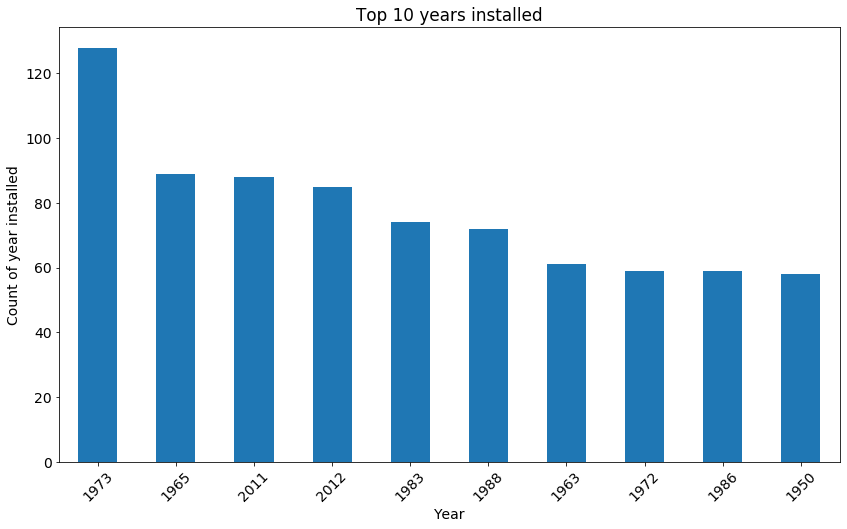

In [133]:
df.INSTYEAR.dropna().astype(int).value_counts().head(10).plot.bar()
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.ylabel('Count of year installed')
plt.xlabel('Year')
plt.title('Top 10 years installed')
plt.show()

In [109]:
df.COMMENTS.value_counts().head(10)

 APPLIED  HTH                                                                                           518
APPLIED HTH                                                                                             513
Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,                       391
Area cleaned and disinfected                                                                            112
Spill ContainedReturned to SystemArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,     106
CLEANED MAIN                                                                                             84
REPAIRED MAIN - HTH                                                                                      80
 APPLIED  HTH, REPAIRED MAIN                                                                             64
Spill ContainedArea Cleaned and Disinfected                                                              54
AREA CLEANED AND DISINFECTED

In [166]:
service = pd.read_csv('service_data.csv')
service.head()

,Category,CASEID,OPENEDDATETIME,SLA_Date,CLOSEDDATETIME,Late (Yes/No),Dept,REASONNAME,TYPENAME,CaseStatus,SourceID,OBJECTDESC,Council District,XCOORD,YCOORD,Report Starting Date,Report Ending Date
0,Streets & Infrastructure,1010126853,12/10/2011,12/11/2011,3/5/2020,YES,Trans & Cap Improvements,Storm Water,Tree Fallen,Closed,Constituent Call,ELM CREEK and WURZBACH RD,8,2113584.0,13747492.0,6/13/2019,6/13/2020
1,Streets & Infrastructure,1010126880,12/10/2011,12/13/2011,3/5/2020,YES,Trans & Cap Improvements,Streets,Barricade - Misc. Special Event/Emergency,Closed,Constituent Call,"1600 CENTENNIAL BV, San Antonio, 78211",5,2116553.0,13684805.0,6/13/2019,6/13/2020
2,Information,1010338011,5/25/2012,NaN,1/27/2020,NO,Knowledge Management,Knowledge,Knowledge Solution Extra,Closed,Constituent Call,"310 ROOSEVELT AV, San Antonio, 78210",5,2132295.0,13693603.0,6/13/2019,6/13/2020
3,Graffiti,1010444245,8/15/2012,8/30/2012,NaN,YES,Code Enforcement Services,Graffiti,Graffiti Public Property,Open,Web Portal,"600 NOGALITOS ST, San Antonio, 78204",5,2125683.0,13695548.0,6/13/2019,6/13/2020
4,Property Maintenance,1010888252,6/6/2013,8/9/2013,NaN,YES,Code Enforcement Services,Code Enforcement (IntExp),Alley-Way Maintenance,Open,Web Portal,"6043 CASTLE QUEEN, San Antonio, 78218",2,2169702.0,13725769.0,6/13/2019,6/13/2020


In [167]:
service.shape

(571737, 17)